In [14]:
import networkx as nx
import numpy as np
import pandas as pd 

from ete3 import Tree
import utilities.validate_trees as tree_val

import sys
import os

from tqdm import tqdm_notebook

import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt

In [2]:
meta = pd.read_csv("../JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col = 0)

In [3]:
labels = []
tree_fps = []
lg_to_tree = {}
i = 0
for tree_dir in tqdm_notebook(os.listdir("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees")):
    tree_dir = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/" + tree_dir + "/"
    if not os.path.isdir(tree_dir):
        continue
    
    lg = tree_dir.split("/")[-2][2:]
    fps = [fp for fp in os.listdir(tree_dir) if ".processed.pkl" in fp and 'nj' not in fp]
    cmfp = [fp for fp in os.listdir(tree_dir) if "_character_matrix.txt" in fp]
    if len(fps) > 0:
#             tree = nx.read_gpickle(tree_dir + fps[0]).get_network()
#             for e in tree.edges():
#                 print(e[0].get_mut_length(e[1]))
            try:
                tree = nx.read_gpickle(tree_dir + fps[0]).get_network()
                lg_to_tree[int(lg)] = tree_val.assign_edge_lengths(tree)
                tree_fps.append(tree_dir + fps[0])
                cmfp = tree_dir + cmfp[0]
                labels.append(int(lg))
                cm = pd.read_csv(cmfp, sep='\t', index_col = 0, dtype=str)
            except:
                i += 1

assigning edge lengths: 100%|██████████| 1167/1167 [00:00<00:00, 144443.38it/s]

Creating pairs to compare: 100%|██████████| 1114/1114 [00:01<00:00, 881.88it/s]


Finding LCAs for all pairs...
Computing pairwise distances...
[0.18421053 0.23684211 0.21052632 ... 0.39473684 0.18421053 0.21052632]


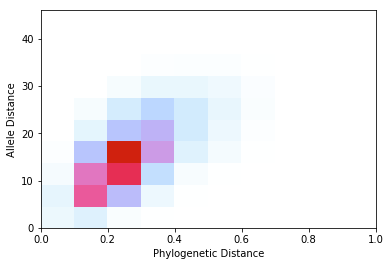

In [18]:
tree_dists, edit_dists, all_pairs, diam, n_targets = tree_val.compute_pairwise_dist_nx(lg_to_tree[5])
print(tree_dists)
hist = plt.hist2d(tree_dists,edit_dists, cmap=cc.cm.CET_L19)
xlab = plt.xlabel("Phylogenetic Distance")
ylab = plt.ylabel("Allele Distance")


plt.show()

In [ ]:
all_tree_dists = []
all_edit_dists = []

max_diam, max_targets = 0,0
for tree in tqdm_notebook(lg_to_tree.values()):
    
    tree_dists, edit_dists,all_pairs,diam,n_targets = tree_val.compute_pairwise_dist_nx(tree)
    #tree_dists /= (n_targets)**2
    #edit_dists /= (n_targets)**2
    
    all_tree_dists += list(tree_dists)
    all_edit_dists += list(edit_dists)
    
    max_diam = max(max_diam, diam)
    max_targets = max(max_targets, n_targets)



In [ ]:
tree_val.dist_plotter(all_tree_dists, all_edit_dists, '2D-Hist', diam=20, n_targets = 20, out_fp = 'all_phy_vs_edit.pdf')

In [ ]:
intra_dists = []
intra_edit_dists = []

max_diam, max_targets = 0,0
for n in tqdm_notebook(lg_to_tree.keys()):
    
    tree = lg_to_tree[n]
    if n in [1,2,3]:
        continue
        
    tree_dists, edit_dists,all_pairs,diam,n_targets = tree_val.compute_pairwise_dist_nx(tree, compare_method = "intra", meta_item = meta['sampleID'])
    #tree_dists /= (n_targets)**2
    #edit_dists /= (n_targets)**2
    
    intra_dists += list(tree_dists)
    intra_edit_dists += list(edit_dists)
    
    max_diam = max(max_diam, diam)
    max_targets = max(max_targets, n_targets)

In [ ]:
tree_val.dist_plotter(intra_dists, intra_edit_dists, '2D-Hist', diam=20, n_targets = 20, out_fp = 'intra_phy_vs_edit.pdf')